### Fully Conented Neural Network

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import time

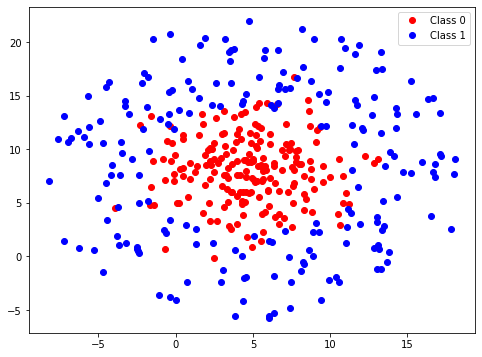

In [2]:
# Synthetic data
m_= 200
mu = np.array([5,8])
sigma = np.array([[10,0],[0,10]])
X1 = np.random.multivariate_normal(mu,sigma,m_)

phi = np.random.uniform(0,2*np.pi,m_).reshape(-1,1)
r = 6 + np.random.uniform(0,8,m_).reshape(-1,1)
X2 = np.concatenate((r*np.cos(phi)+mu[0],r*np.sin(phi)+mu[1]),1)

plt.figure(figsize=(8,6))
plt.plot(X1[:,0],X1[:,1],'ro',label = 'Class 0')
plt.plot(X2[:,0],X2[:,1],'bo',label = 'Class 1')
plt.legend()
plt.show()

**Fully connected model:** consisting of the two inputs ($x_1$ and $x_2$), two hidden layers,
and an output layer. Let's use 4 units in layer 1 and 3 units in layer 2. Since layer
3 is the output layer and we have a binary classification problem, the output layer will
have just one sigmoid unit. We'll use ReLU for the hidden layers.

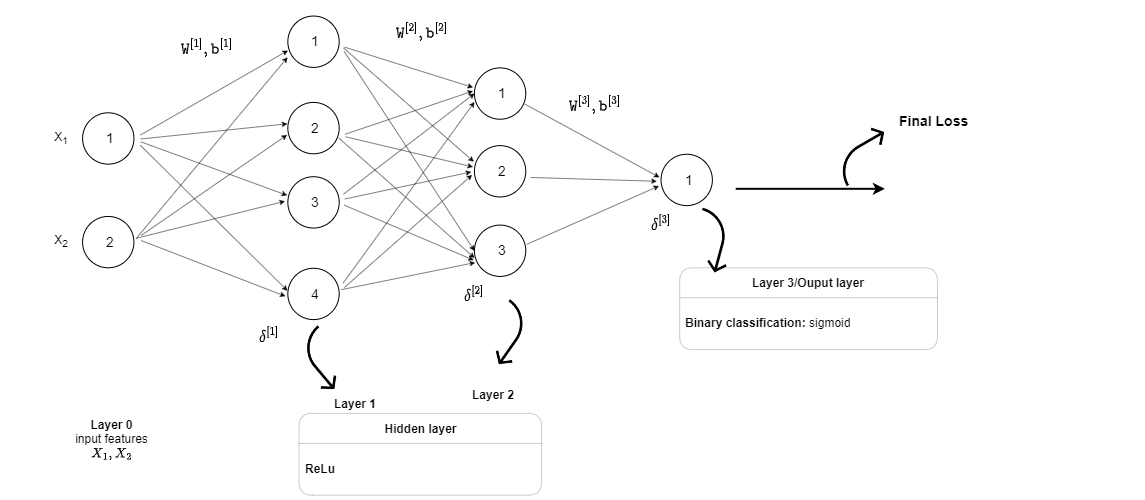

**Layer 0**: 2 inputs feature $x_1$ and $x_2$

**layer 1**: 4 units $\rightarrow$ output 4 features
- $\mathtt{W}^{[1]}: 4x2$
- $\mathbf{b}^{[1]}: 4x1$

**layer 2**: 3 units $\rightarrow$ output 3 features
- $\mathtt{W}^{[2]}: 3x4$
- $\mathbf{b}^{[2]}: 3x1$

**layer 3**: 1 units $\rightarrow$ output 1 result
- $\mathtt{W}^{[1]}: 1x3$
- $\mathbf{b}^{[1]}: 1x1$

**Activation function**
- Sigmoid
$$\mathtt{g}(z) = \frac{1}{1 + e^{-z}} ; \quad
\hat y = \begin{cases}
0 & \quad \text{if $\mathtt{g}(z) \leq 0.5$} \\ 
1 & \quad \text{otherwise}
\end{cases}$$

- ReLu

$$\mathtt{g}(z) = \max(z,0); \quad
\hat y = \begin{cases}
z & \quad \text{if $\mathtt{g}(z) \geq 0$} \\ 
0 & \quad \text{otherwise}
\end{cases}$$

- Hyperbolic tangent (TANH)
- Softmax

**Model Parameters**

**L**: hidden layer; **n**: input features; **$m^{[j]}$**: unit in layer j
- Weight: $\mathtt{W}$
$$\mathtt{W}^{[j]} = \underbrace{\begin{vmatrix}w_{11} & w_{12} & .. & w_{1n} \\ w_{21} & w_{22} & .. & w_{2n} \\ : & : & .. & : \\ w_{m1} & w_{m2} & .. & w_{mn} \end{vmatrix}}_{\text{hidden_unit} \times \text{input_feature}}
$$

- Bias: $\mathtt{b}$
$$\mathtt{b}^{[j]} = \underbrace{\begin{vmatrix}b_{1} \\ b_{2} \\ : \\ b_{m} \end{vmatrix}}_{\text{hidden_unit} \times 1}
$$

- Activation functions $\mathtt{g}(z)$
- $\mathtt{z}$ is the linear response  $\mathtt{z} = \mathtt{w}^{T}x + b$
- $\mathtt{a}$ is the output of the activation function of the $i^{th}$ unit in the $j^{th}$ layer: $\mathtt{a}^{[0]}_{i} = X_{i}$ , ...; $\mathtt{a}^{[1]}_{1} = g(z^{[1]}_{1})$ ...
- Delta: $$\delta^{[L]} = (\mathtt{a}^{[L]} - y); \delta^{[i-1]} = diag(\mathtt{g}^{'}(z^{[i-1]})).\mathtt{w}^{[i]T}.\delta^{[i]}$$

**Initialize the weights**
- Small random normal values with mean 0
$$w^{[i]}_{jk} \sim \mathcal{N}(0,0.1)$$
- Xavier/He initialization
$$w^{[i]}_{jk} \sim \mathcal{N} \left( 0,\sqrt{\frac{2}{n^{[i]}+n^{[i-1]}}} \right) ; n^{[i]} \small 
\text{is the number of units in layer i}$$

In [3]:
X = np.concatenate((X1,X2),0)
y = np.concatenate((np.ones((m_,1)),np.zeros((m_,1))),0)

In [4]:
# Neural network model

# Activation function
def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_der(z):
    a = sigmoid(z)
    return a*(1-a)

def relu(z):
    return np.where(z>0,z,0)

def relu_der(z):
    return np.where(z>0,1,0)

#Initial parameters
n_unit1 = 32
n_unit2 = 16
W = {}
W[1]=np.random.normal(0,0.1,(n_unit1,2))
W[2]=np.random.normal(0,0.1,(n_unit2,n_unit1))
W[3]=np.random.normal(0,0.1,(1,n_unit2))

b ={}
b[1]=np.zeros((n_unit1,1)) + 0.5
b[2]=np.zeros((n_unit2,1)) + 0.5
b[3]=np.zeros((1,1))

g ={}
g[1]=relu
g[2]=relu
g[3]=sigmoid

gprime ={}
gprime[1] =relu_der
gprime[2] =relu_der
gprime[3] =sigmoid_der

# Forward propagation
def forward(W,b,z,a,g,x):
    L = len(W)
    a[0]=x
    for l in range(1, L+1):
        z[l]=W[l]@a[l-1]+b[l]
        a[l]=g[l](z[l])
        
# Backpropagation        
def backward(W, a, z,delta,y):
    L = len(W)
    dW = {}
    db = {}
    delta[L] = a[L] - y
    for l in range(L,0,-1):
        # Calculate gradient for weights
        dW[l]=delta[l]@a[l-1].T
        # Calculate gradient for biases
        db[l]=delta[l]
        # Calculate previous layer's deltas
        if l>1:
            delta[l-1] = np.diag(gprime[l-1](z[l-1]).reshape(-1))@W[l].T@delta[l]
    return dW,db
def update_weights(W,b,dW,db,alpha):
    L = len(W)
    for l in range(1, L+1):
        W[l] = W[l] - alpha *dW[l]
        b[l] = b[l] - alpha *db[l]
        
# predict function
def predict(W,b,X):
    m = X.shape[0]
    L = len(W)
    a={}
    z={}
    results = np.zeros((m,1))
    for i in range(m):
        x = X[i,:].reshape(-1,1)
        forward(W,b,z,a,g,x)
        results[i] = a[L]
    return np.where(results>0.5,1.0,0.0)

def accuracy(X,y,W,b):
    m = X.shape[0]
    a={}
    z={}
    sum = 0
    y_pred = []
    for i in range(m):
        x = X[i,:].reshape(-1,1)
        target = y[i,:].reshape(-1,1)
        forward(W,b,z,a,g,x)
        sum += np.where(a[L]>0.5,1.0,0.0) == target
    return sum[0,0]/m

In [5]:
# Training loop
a = {}
z = {}
delta = {}

epochs = 1000
alpha = 0.001
m = X.shape[0]
L = len(W)
loss_epoch = []
for epoch in tqdm(range(epochs),desc = "Progress Bar"):
    time.sleep(0)
    index = np.arange(m)
    np.random.shuffle(index)
    iter_loss = 0
    for iter in range(m):
        x = X[index[iter],:].reshape(-1,1)
        target = y[index[iter],:].reshape(-1,1)
        forward(W,b,z,a,g,x)
        dW,db =  backward(W, a, z,delta,target)
        update_weights(W,b,dW,db,alpha)
        loss = (- (target*np.log(a[L]) + (1- target)*np.log(1-a[L]))).sum() #cross entropy loss
        iter_loss += loss
    loss_epoch.append(iter_loss/m)
    if epoch%100 ==0:
        print('Epoch %d loss %f' %(epoch,iter_loss/m))

Progress Bar:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 loss 0.715584
Epoch 100 loss 0.252725
Epoch 200 loss 0.227632
Epoch 300 loss 0.215420
Epoch 400 loss 0.207120
Epoch 500 loss 0.195019
Epoch 600 loss 0.194284
Epoch 700 loss 0.190044
Epoch 800 loss 0.188101
Epoch 900 loss 0.182403


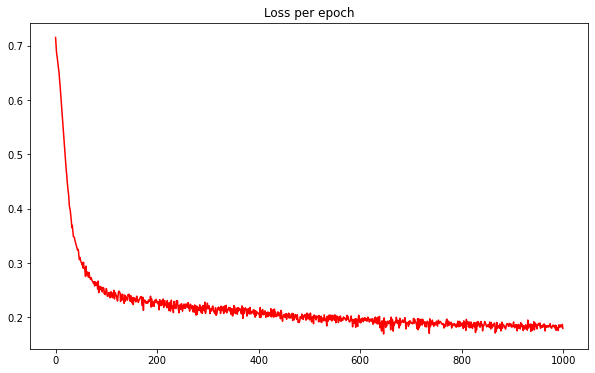

In [6]:
plt.figure(figsize = (10,6))
plt.plot(np.arange(epochs),loss_epoch,'r-')
plt.title('Loss per epoch')
plt.show()

In [10]:
pred = predict(W,b,X)

In [7]:
print('Training accuracy:',accuracy(X,y,W,b))

Training accuracy: 0.9175


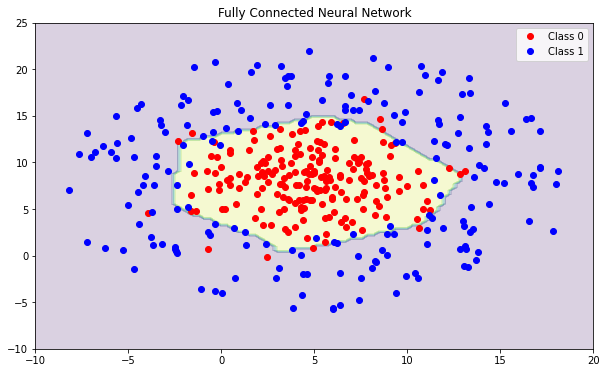

In [8]:
# Plot result
plt.figure(figsize = (10,6))
plt.plot(X1[:,0],X1[:,1],'ro',label='Class 0')
plt.plot(X2[:,0],X2[:,1],'bo',label='Class 1')

# Overlay colored regions
grid_x,grid_y = np.mgrid[-10:20:100j,-10:25:100j]
grid_xy = np.vstack([grid_x.ravel(),grid_y.ravel()]).T
z = predict(W,b,grid_xy).reshape((100,100))
plt.contourf(grid_x,grid_y,z,alpha = 0.2)


plt.title('Fully Connected Neural Network')
plt.legend()
plt.show()